12/17/18
BTC Prediction

In [1]:
import requests
import io
import os
import math

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from IPython.display import display

In [2]:
# 1Token's API address
tokenapi = 'http://hist-quote.1tokentrade.cn'

Run the following cell to extract token from `token.txt` in this same directory.

In [3]:
# Retrieve API token
current_path = os.getcwd()
with open(current_path + '/token.txt') as file:
    ot_key = file.read().splitlines()[0]

The following two cells are sample API calls, not used for our data.

In [4]:
# @hidden_cell
# Query all contracts for a certain date
params = {
    'date' : '2018-02-02',
}
# r = requests.get(tokenapi + '/ticks/contracts', headers = {'ot-key' : ot_key}, params = params)
# r.json()

In [5]:
# Query a single price at date/contract
params = {
    'contract' : 'binance/btc.usdt',
    'date' : '2018-02-02',
}
# r = requests.get(tokenapi + '/ticks/simple' , headers = {'ot-key' : ot_key}, params = params)
# r

Querying 1Token's "candle" data. 
Currently querying for the contract 'binance/btx.usdt'.

In [6]:
# Query "candlestick" data
params = {
#     'since' : '2013-12-10',
#     'since' : '2017-12-21',
    'since' : '2018-12-11',
    'until' : '2018-12-21',
    'contract' : 'binance/btc.usdt',
#     'duration' : '1d',
    'duration' : '1m',
    'format' : 'csv'
}
r = requests.get(tokenapi + '/candles' , headers = {'ot-key' : ot_key}, params = params, stream = True)

# Write to local file
df = pd.read_csv(io.StringIO(r.text))   
df.to_csv(current_path + '/btc-historical-data.csv')
print("Number of rows:", df.size / 6)
df.head()

Number of rows: 14400.0


,close,high,low,open,timestamp,volume
0,3433.40,3436.78,3432.39,3434.01,1544486400,19.362386
1,3425.85,3435.26,3424.01,3433.62,1544486460,49.151693
2,3423.26,3431.02,3423.26,3428.00,1544486520,9.487126
3,3425.19,3427.95,3423.57,3424.52,1544486580,10.325669
4,3422.83,3426.81,3422.67,3425.20,1544486640,8.280380


Following cell is just used to plot the current DataFrame:

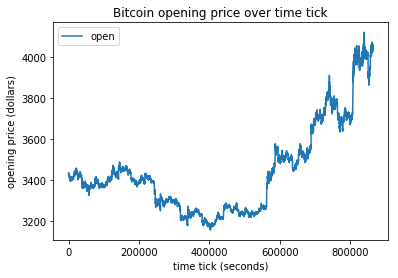

In [7]:
# Plot opening price across entire set
df_plot = df.drop(labels=['close', 'high', 'low', 'volume'], axis=1)
earliest_timestamp = df_plot['timestamp'][0]
# df_plot['timestamp'] = df_plot['timestamp'].apply(lambda x : (x - earliest_timestamp) / 60 / 60 / 24)
df_plot['timestamp'] = df_plot['timestamp'].apply(lambda x : (x - earliest_timestamp))
a = df_plot.plot(x = 'timestamp', y = 'open', \
                     title='Bitcoin opening price over time tick')
a.set_ylabel("opening price (dollars)")
a.set_xlabel("time tick (seconds)")
display(a)

We will reduce the features of our data down to "close", "volume", "hl_pct", "pct_change".  
"hl_pct" will stand for high-low percentage - the percent change between the high and low of a given tick.  
"pct_change" will stand for percent change - the percent change between open and close of a given tick.  
I will be trying to predict the closing price `forecast_out` ticks away.
<!--I will be trying to predict the pct_change for a given tick. Positive pct_change will mean a long, negative pct_change will mean a short. -->

In [8]:
df_reduced = df.drop(labels=['timestamp'], axis=1)
df_reduced['hl_pct'] = (df_reduced['high'] - df_reduced['low']) / df_reduced['low'] * 100.0
df_reduced['pct_change'] = (df_reduced['close'] - df_reduced['open']) / df_reduced['open'] * 100.0
df_reduced = df_reduced.drop(labels=['high', 'low', 'open'], axis=1)

forecast_out = 10
forecast_col = 'close'
df_reduced['label'] = df_reduced[forecast_col].shift(-forecast_out)
df_reduced.dropna(inplace=True)
display(df_reduced[:20])
display(df_reduced.tail())

,close,volume,hl_pct,pct_change,label
0,3433.40,19.362386,0.127899,-0.017763,3422.29
1,3425.85,49.151693,0.328562,-0.226292,3422.97
2,3423.26,9.487126,0.226685,-0.138273,3420.02
3,3425.19,10.325669,0.127937,0.019565,3420.27
4,3422.83,8.280380,0.120958,-0.069193,3418.89
5,3420.66,23.359071,0.145614,-0.067777,3421.00
6,3422.34,10.720015,0.109081,-0.025123,3416.13
7,3422.73,33.902123,0.170233,0.058760,3417.35
8,3425.30,43.512169,0.204849,0.075671,3418.80
9,3423.94,11.524962,0.118644,-0.039705,3417.98


,close,volume,hl_pct,pct_change,label
14385,4040.01,75.850425,0.232916,-0.113732,4057.01
14386,4040.56,35.601706,0.256512,-0.017321,4052.22
14387,4035.00,18.979861,0.137794,-0.137605,4052.09
14388,4039.25,22.752791,0.187165,0.089205,4055.36
14389,4039.16,30.551036,0.224181,-0.025741,4049.62


Now, the next step is to split the training/testing data.

In [9]:
percent_training = .8
X = np.array(df_reduced.drop(['label'], axis=1))
y = np.array(df_reduced['label'])
# X = preprocessing.scale(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1 - percent_training))
display(X_train.shape)
display(X_test.shape)

(11512, 4)

(2878, 4)

Now, we can train linear regression model and check its accuracy.

In [10]:
clf = LinearRegression()
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
accuracy

0.9969741862366558

In [11]:
# Split training/testing data
percent_training = .8
div = math.floor(len(df) * percent_training)
training = df.drop(labels=np.arange(len(df))[div:])
testing = df.drop(labels=np.arange(len(df))[:div])
print("Split data such that training has " + str(len(training)) + \
      " points, and testing has " + str(len(testing)) + " points.")

Split data such that training has 11520 points, and testing has 2880 points.
